# Classificação de imagens em PyTorch

Tutorial adaptado de : https://www.geeksforgeeks.org/how-to-implement-neural-networks-in-pytorch/

Dataset Utilizado: https://pt.wikipedia.org/wiki/Banco_de_dados_MNIST

# Imports


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Parâmetros e Pré-processamaneto

In [2]:
batch_size = 64 # O Treinamento em batches/bateladas traz estabilidade e aproveita o paralelismo das gpus
num_epochs = 30
learning_rate = 0.01

# Transforms para pré-processamento (e também aumento de dados, mas não aqui)
transform = transforms.Compose([
    transforms.ToTensor(), # Converte uma Imagem para Um tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliza ao redor da média e do desvio padrão
])

# Dados e Loaders

In [3]:
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Definindo e Instanciando o Modelo

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)  # View converte um tensor p/ um novo formato, nesse caso achatamos o tensor (O tamanho correto em -1 é inferido)
        x = F.relu(self.fc1(x))  # Função de Ativação: ReLU (Rectifier Linear Unit)
        x = self.fc2(x)  # Output layer
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

# Instanciando Custo e Otimizador

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Definindo os loops de treinamento e de teste

In [6]:
# Implementação simples  para o cálculo da acurácia ao longo do bach:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return torch.sum(preds == labels).item() / len(labels)

#Loop de Treinamento
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for i, (inputs, labels) in enumerate(train_loader): # O train_loader vai nos dando os batches
        inputs, labels = inputs.to(device), labels.to(device) # temos que passar os dados para o device, assim como o modelo
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(outputs, labels)
        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch}, Batch {i+1}, Loss: {running_loss / 200:.4f}, Accuracy: {running_acc / 200:.4f}')
            running_loss = 0.0
            running_acc = 0.0

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}')

# Executando Treinamento e Teste, Visualizando os Resultados

Epoch 1, Batch 200, Loss: 1.1082, Accuracy: 0.7452
Epoch 1, Batch 400, Loss: 0.5051, Accuracy: 0.8688
Epoch 1, Batch 600, Loss: 0.4023, Accuracy: 0.8897
Epoch 1, Batch 800, Loss: 0.3585, Accuracy: 0.8981
Test Loss: 0.3062, Test Accuracy: 0.9125
Epoch 2, Batch 200, Loss: 0.3057, Accuracy: 0.9133
Epoch 2, Batch 400, Loss: 0.2976, Accuracy: 0.9160
Epoch 2, Batch 600, Loss: 0.2883, Accuracy: 0.9168
Epoch 2, Batch 800, Loss: 0.2815, Accuracy: 0.9192
Test Loss: 0.2500, Test Accuracy: 0.9304
Epoch 3, Batch 200, Loss: 0.2613, Accuracy: 0.9259
Epoch 3, Batch 400, Loss: 0.2416, Accuracy: 0.9302
Epoch 3, Batch 600, Loss: 0.2346, Accuracy: 0.9352
Epoch 3, Batch 800, Loss: 0.2353, Accuracy: 0.9341
Test Loss: 0.2149, Test Accuracy: 0.9384
Epoch 4, Batch 200, Loss: 0.2193, Accuracy: 0.9371
Epoch 4, Batch 400, Loss: 0.2169, Accuracy: 0.9372
Epoch 4, Batch 600, Loss: 0.2018, Accuracy: 0.9441
Epoch 4, Batch 800, Loss: 0.2032, Accuracy: 0.9452
Test Loss: 0.1900, Test Accuracy: 0.9452
Epoch 5, Batch 200, 

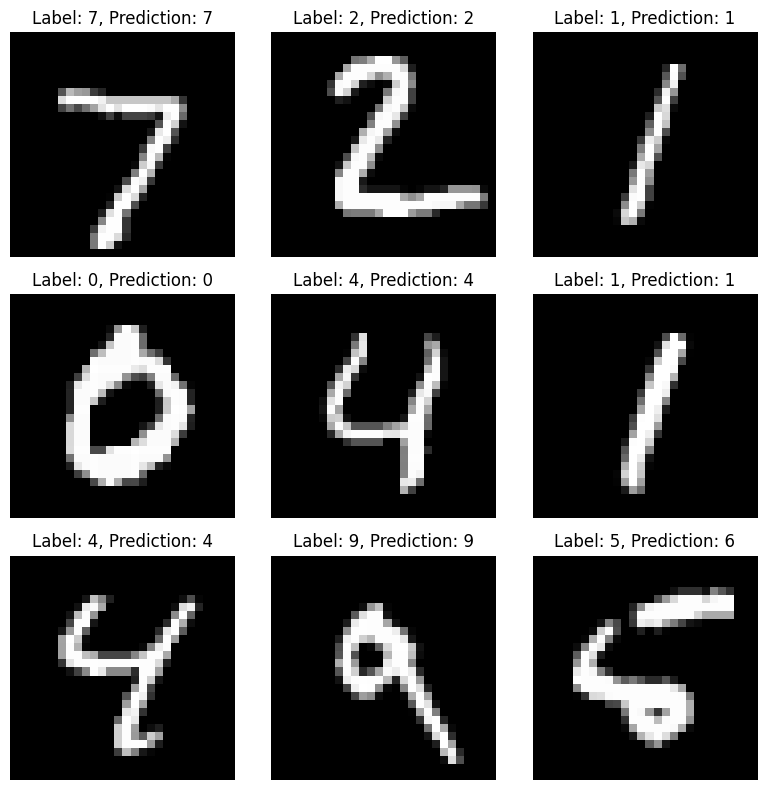

In [7]:
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, criterion, optimizer, epoch)
    test(model, device, test_loader, criterion)

# Visualize sample images with predictions
samples, labels = next(iter(test_loader))
samples = samples.to(device)
outputs = model(samples)
_, preds = torch.max(outputs, 1)

samples = samples.cpu().numpy()
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(samples[i].squeeze(), cmap='gray')
    ax.set_title(f'Label: {labels[i]}, Prediction: {preds[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()